### prepare


In [1]:
import sys
sys.path.append('../')
sys.path.append('../../')

In [2]:
import time
from typing import List
from pathlib import Path
import pickle

import hydra
from omegaconf import DictConfig

import gym
from gym.spaces import Box

import numpy as np
from sklearn.utils import check_random_state
import matplotlib.pyplot as plt

import pandas as pd
from pandas import DataFrame
import torch
import seaborn as sns
from cycler import cycler

from basicgym import BasicEnv

from tutorial.function_before import train_behavior_policy
from tutorial.function_before import obtain_logged_dataset
from tutorial.function_before import train_candidate_policies
from tutorial.function_before import off_policy_evaluation


/Users/ren/tutorial_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### function

In [28]:
def visualize(
    bias_result_df,
    variance_result_df,
    mse_result_df,
    estimators,
    ESTIMATORS,
    x_scales,
    x_label,
    log_dir="../tutorial/logs/",
    yscale_log = False,
    xscale_log = False,
):

    color_dict = {
        "dm": "#E24A33",
        "tis": "#348ABD",
        "pdis": "#988ED5",
        "dr": "#777777",
        "sntis": "#8EBA42",
        "snpdis": "#FBC15E",
        "sndr": "#FFB5B8",
        "sm_is": "#FFA726",
        "sm_dr": "#17BECF",
        "sm_snis": "#F781BF",
        "sm_sndr": "#8C564B",
        # "sam_is": "#00FF00",
        "sam_is": "#FFA726",
        "sam_dr": "#008080",
        "sam_snis": "#000080",
        "sam_sndr": "#4B0082",
        # "drl": "#800000"
        "drl": "#F781BF"
    }

    plt.style.use("ggplot")
    markers = ["o", "v", "^", "s", "p", "P", "*", "h", "X", "D", "d"]
    metric_list = ['squared bias', 'variance', 'mse']

    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(30, 7), tight_layout=True)

    for idx, metric in enumerate(metric_list):
        ax = axs[idx]  # 現在のサブプロットを選択

        if metric == 'squared bias':
            result_df = bias_result_df
        elif metric == 'variance':
            result_df = variance_result_df
        else:
            result_df = mse_result_df

        for i, estimator in enumerate(estimators):
            data = result_df[result_df['est'] == estimator]
            data = data.query(f"({x_label} in {x_scales})")
            ax.plot(
                np.array(x_scales),
                data[metric],
                color=color_dict[estimator],
                marker=markers[i],
                label=ESTIMATORS[i],
            )
            
            ax.legend(loc="upper right", fontsize=30)


            ax.fill_between(
                np.array(x_scales),
                data['lower'],
                data['upper'],
                color=color_dict[estimator],
                alpha=0.3,
                label='',
            )

        ax.set_title(metric,  fontsize=35)  
        ax.set_yticks([0, 2, 4, 6, 8, 10])
        if idx == 0:  
            ax.set_yticklabels(['0', '2', '4', '6', '8', '10'])
            
        else:
            ax.set_yticklabels([]) 

        ax.tick_params(axis="y", labelsize=25)
        ax.set_xscale("log") if xscale_log else None
        ax.set_xlabel(f"number of trajectory", fontsize=30)
        ax.set_xticks(x_scales)
        ax.set_xticklabels(x_scales, fontsize=25)

    # path_ = Path(log_dir + "/results/fig")
    path_ = Path(f"../tutorial/tutorial_figs/{x_label}")
    path_.mkdir(exist_ok=True, parents=True)
    save_path = Path(path_ / f"result_fig_{x_label}_{ESTIMATORS}.png")
    fig.savefig(save_path, dpi=300, bbox_inches="tight")


In [4]:
def main(
    variable_name,
    n_random_state,
    log_dir,
    behavior_tau = 1.0,
    candidate_epsilons = [1.0],
    behavior_sigma = 1.0,
    candidate_sigmas = [1.0],
    action_type = 'discrete',
):
    #discrete
    env_name="BasicEnv-discrete-v0"
    action_type='discrete'
    behavior_policy_name=f"ddqn_softmax_{behavior_tau}"
    candidate_policy_name=f"cql_eps_{candidate_epsilons[0]}"

    #continuous
    # env_name="BasicEnv-continuous-v0"
    # action_type='continuous'
    # behavior_policy_name=f"sac_gauss_{behavior_sigma}"
    # candidate_policy_name=f"cql_b1_gauss_{candidate_sigmas}"

    base_random_state=12345
    device="cuda:0" if torch.cuda.is_available() else "cpu"
    step_per_trajectory_list = [10, 15, 25, 40]
    # step_per_trajectory_list =  [5, 10, 20, 40, 80]
    step_per_trajectory = 10
    
    # n_trajectories_list=[1600, 3200, 6400]
    # n_trajectories_list=[1600, 3200, 6400, 12800]
    n_trajectories_list=[1600, 3200, 6400, 12800, 25600]

    n_trajectories=8000
    n_actions_list = [2, 4, 6, 8, 10, 12, 14, 16]
    n_actions=5
    n_step_pdis=0

    bias_df_list = []
    variance_df_list = []
    mse_df_list = []

    random_ = check_random_state(base_random_state)
    n_bootstrap_samples = 100
    alpha=0.05

    if variable_name == 'n_trajectories':
        variable_list = n_trajectories_list
    elif variable_name == 'n_actions':
        variable_list = n_actions_list
    elif variable_name == 'step_per_trajectory':
        variable_list = step_per_trajectory_list
    else:
        ValueError


    for variable in variable_list:

        if variable_name == 'n_trajectories':
            n_trajectories = variable
        elif variable_name == 'n_actions':
            n_actions == variable
        elif variable_name == 'step_per_trajectory':
            step_per_trajectory =variable

        env = BasicEnv(
            action_type=action_type, 
            n_actions=n_actions,
            random_state=base_random_state, 
            step_per_episode=step_per_trajectory,
        )

        behavior_policy = train_behavior_policy(
            env_name=env_name,
            env=env,
            behavior_sigma=behavior_sigma,
            behavior_tau=behavior_tau,
            device=device,
            base_random_state=base_random_state,
            log_dir=log_dir,
            variable=variable,
            variable_name=variable_name,
        )

        train_logged_dataset, test_logged_dataset = obtain_logged_dataset(
            env_name=env_name,
            env=env,
            behavior_policy=behavior_policy,
            n_trajectories=n_trajectories,
            n_random_state=n_random_state,
            base_random_state=base_random_state,
            log_dir=log_dir,
            variable=variable,
            variable_name=variable_name,
        )

        candidate_policies = train_candidate_policies(
            env_name=env_name,
            env=env,
            n_trajectories=n_trajectories,
            train_logged_dataset=train_logged_dataset,
            candidate_sigmas=candidate_sigmas,
            candidate_epsilons=candidate_epsilons,
            device=device,
            base_random_state=base_random_state,
            log_dir=log_dir,
            variable=variable,
            variable_name=variable_name,
        )

        input_dict, policy_value_dict = off_policy_evaluation(
            env_name=env_name,
            env=env,
            n_trajectories=n_trajectories,
            test_logged_dataset=test_logged_dataset,
            candidate_policies=candidate_policies,
            n_step_pdis=n_step_pdis,
            device=device,
            base_random_state=base_random_state,
            log_dir=log_dir,
            variable=variable,
            variable_name=variable_name,
        )

        input_dict_ = input_dict.get(
            behavior_policy_name=behavior_policy_name,
            dataset_id=0,
        )

        dict = {i : DataFrame() for i in input_dict_.keys()}
        bias_dict = {i : 0 for i in input_dict_.keys()}
        variance_dict = {i : 0 for i in input_dict_.keys()}
        mse_dict = {i : 0 for i in input_dict_.keys()}
        lower_bias = []
        upper_bias = []
        lower_variance = []
        upper_variance = []
        lower_mse = []
        upper_mse = []

        for dataset_id_ in range(n_random_state):
            for eval_policy in input_dict_.keys():
                dict[eval_policy] = pd.concat([dict[eval_policy] , DataFrame(policy_value_dict[behavior_policy_name][dataset_id_][eval_policy], index=[dataset_id_])])

        for eval_policy in input_dict_.keys():
            # bias_square
            bias_dict[eval_policy] = np.square(dict[eval_policy].mean(axis=0) - dict[eval_policy].mean(axis=0)['on_policy'])
            variance_dict[eval_policy] = dict[eval_policy].var(axis=0)
            mse_dict[eval_policy] = bias_dict[eval_policy] + variance_dict[eval_policy]


        for estimator in dict[eval_policy].columns.values:
            samples = dict[eval_policy][estimator]
            boot_samples_bias = np.square([
                np.mean(random_.choice(samples - dict[eval_policy].mean(axis=0)['on_policy'], size=samples.shape[0]))
                for i in range(n_bootstrap_samples)
            ])
            boot_samples_variance = [
                np.var(random_.choice(samples, size=samples.shape[0]), ddof=1)
                for i in range(n_bootstrap_samples)
            ]
            boot_samples_mse = boot_samples_bias + boot_samples_variance

            lower_bias.append(np.percentile(boot_samples_bias, 100 * (alpha / 2)))
            upper_bias.append(np.percentile(boot_samples_bias, 100 * (1.0 - alpha / 2)))
            lower_variance.append(np.percentile(boot_samples_variance, 100 * (alpha / 2)))
            upper_variance.append(np.percentile(boot_samples_variance, 100 * (1.0 - alpha / 2)))
            lower_mse.append(np.percentile(boot_samples_mse, 100 * (alpha / 2)))
            upper_mse.append(np.percentile(boot_samples_mse, 100 * (1.0 - alpha / 2)))         


        bias_df = DataFrame(DataFrame(bias_dict[candidate_policy_name]).stack())\
        .reset_index(0).rename(columns={"level_0": "est", 0: "squared bias"})
        bias_df['lower']=lower_bias
        bias_df['upper']=upper_bias
        bias_df[variable_name] = variable
        bias_df_list.append(bias_df)
        variance_df = DataFrame(DataFrame(variance_dict[candidate_policy_name]).stack())\
        .reset_index(0).rename(columns={"level_0": "est", 0: "variance"})
        variance_df['lower']=lower_variance
        variance_df['upper']=upper_variance
        variance_df[variable_name] = variable
        variance_df_list.append(variance_df)
        mse_df = DataFrame(DataFrame(mse_dict[candidate_policy_name]).stack())\
        .reset_index(0).rename(columns={"level_0": "est", 0: "mse"})
        mse_df['lower']=lower_mse
        mse_df['upper']=upper_mse
        mse_df[variable_name] = variable
        mse_df_list.append(mse_df)


    # aggregate all results 
    bias_result_df = pd.concat(bias_df_list).reset_index(level=0)
    variance_result_df = pd.concat(variance_df_list).reset_index(level=0)
    mse_result_df = pd.concat(mse_df_list).reset_index(level=0)
    

    path_ = Path(log_dir + f"/results/df")
    path_.mkdir(exist_ok=True, parents=True)
    path_bias = Path(path_ / f"bias_result_df_{variable_name}.pkl")
    path_variance = Path(path_ / f"variance_result_df_{variable_name}.pkl")
    path_mse = Path(path_ / f"mse_result_df_{variable_name}.pkl")

    with open(path_bias, "wb") as f:
        pickle.dump(bias_result_df, f)
    with open(path_variance, "wb") as f:
        pickle.dump(variance_result_df, f)
    with open(path_mse, "wb") as f:
        pickle.dump(mse_result_df, f)

    return bias_result_df, variance_result_df, mse_result_df


### main

In [5]:
basic_estimators = ["DM", "TIS", "PDIS", "DR", "SNTIS", "SNPDIS", "SNDR"]
state_marginal_estimators = ["SMIS", "SMDR", "SMSNIS", "SMSNDR"]
state_action_marginal_estimators = ["SAMIS", "SAMDR", "SAMSNIS", "SAMSNDR"]
drl_estimators = ["DRL"]
all_estimators = basic_estimators + state_marginal_estimators + state_action_marginal_estimators + drl_estimators

basic_estimators_name = ["dm", "tis", "pdis", "dr", "sntis", "snpdis", "sndr"]
state_marginal_estimators_name = ["sm_is", "sm_dr", "sm_snis", "sm_sndr"]
state_action_marginal_estimators_name = ["sam_is", "sam_dr", "sam_snis", "sam_sndr"]
drl_estimators_name = ["drl"]
all_estimators_name = basic_estimators_name + state_marginal_estimators_name + state_action_marginal_estimators_name + drl_estimators_name

In [6]:
tmp_log_dir = "logs"

In [7]:
bias_result_df, variance_result_df, mse_result_df =main(
    variable_name = "n_trajectories",
    n_random_state = 100,
    # log_dir="../tutorial/logs_n_trajectories",
    log_dir=f"../tutorial/{tmp_log_dir}",
    behavior_tau = 3.5,
    # behavior_tau = 3.5,
    candidate_epsilons = [0.5],
    behavior_sigma = 1.0,
    candidate_sigmas = [1.0],
    action_type = 'discrete',
)

In [8]:

ESTIMATORS=["DM", "TIS"]
estimators=["dm", "tis"]

x_scales=[1600, 3200, 6400, 12800, 25600]
x_label='n_trajectories'

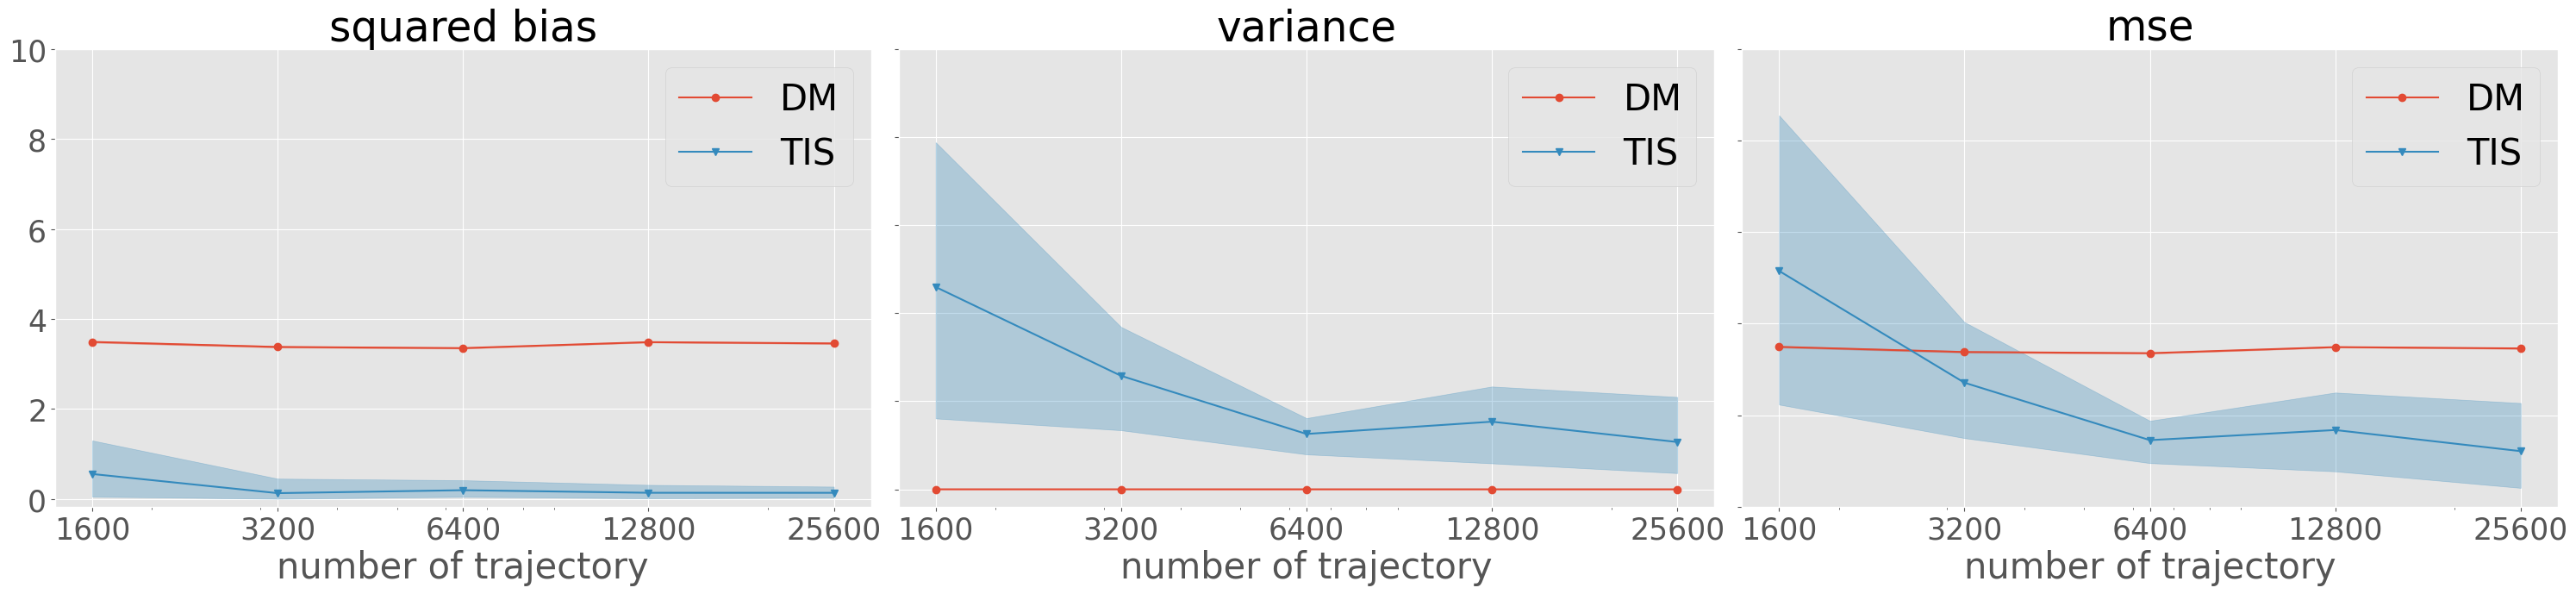

In [29]:
visualize(
    bias_result_df,
    variance_result_df,
    mse_result_df,
    ESTIMATORS=ESTIMATORS,
    estimators=estimators,
    x_scales=x_scales,
    log_dir=f"../tutorial/{tmp_log_dir}",
    x_label=x_label,
    # yscale_log=True,
    xscale_log=True,
)